In [1]:
%matplotlib inline
# packages to load 
# Check the versions of libraries
# Python version
import warnings
warnings.filterwarnings('ignore')
import sys
print('Python: {}'.format(sys.version))

import scipy
print('scipy: {}'.format(scipy.__version__))

import csv
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import (PCA, LatentDirichletAllocation)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.feature_selection import f_regression
# Importing metrics for evaluation

from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor, GradientBoostingClassifier )
from sklearn.linear_model import LogisticRegression


import random as rn
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers
from keras import initializers
from keras.callbacks import (TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
from biosppy.signals import (ecg, tools)
import pywt
from tqdm import tqdm_notebook as tqdm

import math
from itertools import product
# ============= CONSTS =============
TRAIN_FILE_PATH = "data/X_train.csv"
TARGET_FILE_PATH =  "data/y_train.csv"
TEST_FILE_PATH = "data/X_test.csv"

seed=42
NUM_MAX_POINTS = 18154
SAMPLING_RATE=300
USE_WAVE_LETS = False
my_cols = ["id"] + ["x" + str(i) for i in range(NUM_MAX_POINTS)]
# ============= CONSTS =============

np.random.seed(seed)
rn.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

tf.set_random_seed(seed)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)



Python: 3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]
scipy: 1.1.0


Using TensorFlow backend.


In [2]:
#Load train and test set


train_data = pd.read_csv(TRAIN_FILE_PATH, names=my_cols)[1:]
train_data.drop("id", axis=1, inplace=True)

Y_train = pd.read_csv(TARGET_FILE_PATH)
Y_train.drop("id", axis=1, inplace = True)

test_data =  pd.read_csv(TEST_FILE_PATH, names=my_cols)[1:]
id_test = test_data.columns[0]
test_data.drop("id", axis=1, inplace=True)

In [3]:
## ================ FUNCTION DEFS ================ ##

def make_submission(filename, predictions):
    test_data =  pd.read_csv(TEST_FILE_PATH, names=my_cols)[1:]
    test_data["y"] = predictions
    test_data[["id", "y"]].to_csv("submissions/"+filename, index= False)
    

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

def get_feature_from_raw(signal, sampling_rate):
    # filter signal
    order = int(0.3 * sampling_rate)
    filtered, _, _ = tools.filter_signal(signal=signal,
                                      ftype='FIR',
                                      band='bandpass',
                                      order=order,
                                      frequency=[3, 45],
                                      sampling_rate=sampling_rate)

    # segment
    rpeaks, = ecg.hamilton_segmenter(signal=filtered, sampling_rate=sampling_rate)

    # correct R-peak locations
    rpeaks, = ecg.correct_rpeaks(signal=filtered,
                             rpeaks=rpeaks,
                             sampling_rate=sampling_rate,
                             tol=0.05)

    # extract templates
    templates, rpeaks = ecg.extract_heartbeats(signal=filtered,
                                           rpeaks=rpeaks,
                                           sampling_rate=sampling_rate,
                                           before=0.2,
                                           after=0.4)
    return templates
    
def get_features_from_raw_qrs(signal, sampling_rate):
    X = np.zeros((16 + (3*180)), dtype=np.float64)
    ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg.ecg(signal, sampling_rate, show=False)
    rpeaks = ecg.correct_rpeaks(signal=signal, rpeaks=rpeaks, sampling_rate=sampling_rate, tol=0.1)
    
    
    peaks = signal[rpeaks]
    if len(heart_rate) < 2:
        heart_rate = [0, 1]
    if len(heart_rate_ts) < 2:
        heart_rate_ts = [0, 1]
        
    X[0] = np.mean(peaks)
    X[1] = np.min(peaks)
    X[2] = np.max(peaks)
    X[3] = np.mean(np.diff(rpeaks))
    X[4] = np.min(np.diff(rpeaks))
    X[5] = np.max(np.diff(rpeaks))
    X[6] = np.mean(heart_rate)
    X[7] = np.min(heart_rate)
    X[8] = np.max(heart_rate)
    X[9] = np.mean(np.diff(heart_rate))
    X[10] = np.min(np.diff(heart_rate))
    X[10] = np.min(np.diff(heart_rate))
    X[11] = np.max(np.diff(heart_rate))
    X[12] = np.mean(np.diff(heart_rate_ts))
    X[13] = np.min(np.diff(heart_rate_ts))
    X[14] = np.max(np.diff(heart_rate_ts))
    X[15] = np.sum(filtered-signal)
    X[16:180+16] = np.mean(templates, axis=0)
    #X[180+16:2*180+16] = np.min(templates, axis=0)
    X[2*180+16:] = np.max(templates, axis=0)
    X[np.isnan(X)] = 0
    return X
    
    
def get_weights(Y, N):
    cnt_0 = np.sum(Y == 0)
    cnt_1 = np.sum(Y == 1)
    cnt_2 = np.sum(Y == 2)
    cnt_3 = np.sum(Y == 3)
    return {0: cnt_0 / N, 1: cnt_1 / N, 2: cnt_2 / N, 3: cnt_3 / N}

In [4]:
features = list()
sampling_rate = float(SAMPLING_RATE)
for id in tqdm(range(train_data.shape[0])):
    signal = np.array(pd.to_numeric(train_data.iloc[id].dropna()))
    if USE_WAVE_LETS:
        features.append(get_feature_from_raw(signal, sampling_rate))
    else:
        features.append(get_features_from_raw_qrs(signal, sampling_rate))

In [5]:
# precrosses 
if USE_WAVE_LETS:
    X_features = list ()
    y = list()
    for idx, sig in enumerate(features):
        mean = 0
        cnt = 0

        for p in sig:
            mean += p
            cnt += 1
        if cnt > 0:
            X_features.append(mean / cnt)
            y.append(Y_train.iloc[idx])
        else:
            print("{}: Cnt is equal to zero".format(idx))

    X, _ = pywt.dwt(X_features, 'db1')
    y = np.array(y)
else:
    X = np.array(features)
    y = np.array(Y_train.values)

# Get features from test data

In [6]:
features_test = list()
for id in tqdm(range(test_data.shape[0])):
    signal = np.array(pd.to_numeric(test_data.iloc[id].dropna()))
    if USE_WAVE_LETS:
        features_test.append(get_feature_from_raw(signal, sampling_rate))
    else:
        features_test.append(get_features_from_raw_qrs(signal, sampling_rate))
            

In [7]:
if USE_WAVE_LETS:
    X_features_test = list ()
    for sig in features_test:
        mean = 0
        cnt = 0
        for p in sig:
            mean += p
            cnt += 1
        X_features_test.append(mean / cnt)

    X_test, _ = pywt.dwt(X_features_test, 'db1')
else:
    X_test = np.array(features_test)

# Save features to memory

In [8]:
# Export to CSV
print(X.shape)
print(y.shape)
print(X_test.shape)
if USE_WAVE_LETS:
    pd.DataFrame(data=X).to_csv("data/X_train_features.csv", index=False)
    pd.DataFrame(data=y).to_csv("data/y_train_features.csv", index=False)
    pd.DataFrame(data=X_test).to_csv("data/X_test_features.csv", index=False)
else:
    pd.DataFrame(data=X).to_csv("data/X_train_features_qrs.csv", index=False)
    pd.DataFrame(data=y).to_csv("data/y_train_features_qrs.csv", index=False)
    pd.DataFrame(data=X_test).to_csv("data/X_test_features_qrs.csv", index=False)

(5117, 556)
(5117, 1)
(3411, 556)


In [9]:
# read from csv
if USE_WAVE_LETS:
    X= pd.read_csv("data/X_train_features.csv").values
    y= pd.read_csv("data/y_train_features.csv").values
    X_test= pd.read_csv("data/X_test_features.csv").values
else:
    X= pd.read_csv("data/X_train_features_qrs.csv").values
    y= pd.read_csv("data/y_train_features_qrs.csv").values
    X_test= pd.read_csv("data/X_test_features_qrs.csv").values
print(X.shape)
print(y.shape)
print(X_test.shape)

(5117, 556)
(5117, 1)
(3411, 556)


In [11]:
def from_labels_to_vec(Y_labels):
    Y = []
    
    #for y in Y_labels.values:
    for y in Y_labels.values:

        if y == 0:
            v = [1,0,0,0]
        if y == 1:
            v = [0,1,0,0]
        if y == 2:
            v = [0,0,1,0]
        if y == 3:
            v = [0,0,0,1]
        Y.append(v)
    print(Y)
    return Y

def from_vec_to_labels(vecs):
    Y = []
    for y in vecs:
        Y.append(np.argmax(y))
    print(Y)
    return Y


In [12]:
Y = from_labels_to_vec(Y_train)
Y = np.array(Y)
print(Y.shape)

[[1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0

In [25]:
scaler = StandardScaler() 

#X_df = pd.DataFrame(X,index=X[:,0]),
#X_test_df = pd.DataFrame(X_test,index=X_test[:,0]),
#print(X_df)
#print()
#frames = [X_df, X_test_df]
#X_total = pd.concat(frames)

scaler.fit(X)
X_train_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

"""svc = SVC(gamma='auto', class_weight='balanced')
svc.fit(X_train_scaled, y) """

"svc = SVC(gamma='auto', class_weight='balanced')\nsvc.fit(X_train_scaled, y) "

[ 11   8  10   6   4 338 337 292 291 336 290 293 335 339 201 200 545 289
 544 202 376  13 543 546 199 294 356 278 377 334 279 357 536 340 535 538
 541 277 355 537 542 409 528 288 276 532 531 529 527 345 530 214 408 213
 534 533 555 354 539 275 203 540 410 212 378 333 344 280 358 198 476 471
 215 526 341 346 470 412 475 547 295 411 216 469 484 379 413 332 359 472
 380 327 331 274 474 485 381 204 217 360 468 477 407 287 326 382 205 473
 328 206 211 353 361 551 554 483 330 342 467 347 343 553 207 552 414 197
 375 550 300 301 325 548 486 329 383 362 302 218 426 223 208 224 222 299
 491 425 210 220 225 466 421 549 221 273 350 351 296 422 427 482 423 478
 348 352 384 465 374 525 371 219 415 487 420 424 209 492 349 281 226 406
 385 363 370 416 372 481 303 227 373 501 272 428 286 314 315 500 298 229
 313 490 297 417 502 196 228 479 386 419 459 503 458 400 480 493 464 488
 369 324 418 230 401 429 460 507 508 504 447 399 368 271 304 364 448 499
 316 405 443 489 509 505 457 367 317 506 366 442 44

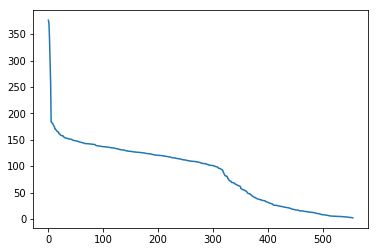

In [199]:
#Extract the features to use with f_regression
from sklearn.feature_selection import f_classif

n_features_fr = 580

features_scores = f_classif(X_train_scaled, Y_train)[0]
#print(features_scores)
y = list(features_scores)
myarray = np.asarray(y)

plt.plot(-1*np.sort(-1*myarray));

indices_fr = myarray.argsort()[-n_features_fr:][::-1]
print(indices_fr)
print(len(indices_fr))


In [200]:
"""X_train_subset = train_data_mean[.columns[indices]]
X_test_subset = test_data_mean[train_data_mean.columns[indices]]


X_train_subset, X_test_subset = fill_NaN(X_train_subset, X_test_subset)
X_train_subset, X_test_subset = scale_data(X_train_subset, X_test_subset)
"""

X_test_subset_scaled = X_test_scaled[:, indices_fr]
X_train_subset_scaled = X_train_scaled[:, indices_fr]
print(X_test_subset_scaled.shape)
print(X_train_subset_scaled.shape)

(3411, 556)
(5117, 556)


In [89]:
import keras
from keras import regularizers

reg = 0.001

# Define the model
model = keras.models.Sequential()


"""model.add(keras.layers.Dense(30, input_shape=(556,)))
model.add(keras.layers.LeakyReLU(alpha=0.1))
        
model.add(keras.layers.Dropout(rate=0.1))"""

units = 100


model.add(keras.layers.Dense(units, input_shape=(556,)))
model.add(keras.layers.LeakyReLU(alpha=0.1))
        
model.add(keras.layers.Dropout(rate=0.1))

model.add(keras.layers.Dense(units))
model.add(keras.layers.LeakyReLU(alpha=0.1))
        
model.add(keras.layers.Dropout(rate=0.1))

model.add(keras.layers.Dense(units))
model.add(keras.layers.LeakyReLU(alpha=0.1))
        
model.add(keras.layers.Dropout(rate=0.1))

model.add(keras.layers.Dense(units))
model.add(keras.layers.LeakyReLU(alpha=0.1))
        
model.add(keras.layers.Dropout(rate=0.1))

model.add(keras.layers.Dense(units))
model.add(keras.layers.LeakyReLU(alpha=0.1))
        
model.add(keras.layers.Dropout(rate=0.1))

model.add(keras.layers.Dense(units=4,
                                  kernel_regularizer=keras.regularizers.l2(1e-6),
                                  activation="softmax"))

print("Compiling model ...")

optimiser = keras.optimizers.Adam(lr=0.001)
model.compile(loss=keras.losses.categorical_crossentropy,
                   optimizer=optimiser,
                   metrics=["categorical_crossentropy"])
print(model.summary())

print("Done")


Compiling model ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 100)               55700     
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_55 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 100)               1

In [90]:
#Model train
import os
lr_callback = keras.callbacks.ReduceLROnPlateau(monitor="acc",
                                                factor=0.5,
                                                patience=0.5,
                                                verbose=0,
                                                cooldown=0,
                                                min_lr=0)
stop_callback = keras.callbacks.EarlyStopping(monitor="acc",
                                              min_delta=0.0001,
                                              patience=11,
                                              verbose=0,
                                              mode="auto")

tensorboard_callback = keras.callbacks.TensorBoard( histogram_freq=0,
                                                   batch_size=128,
                                                   write_graph=True,
                                                   write_grads=False, write_images=False, embeddings_freq=0,
                                                   embeddings_layer_names=None, embeddings_metadata=None)

checkpoint_callback = keras.callbacks.ModelCheckpoint(
            os.path.join('weights', 'weights.h5'),
            monitor='val_loss', verbose=0, save_best_only=True,
            save_weights_only=False, mode='auto', period=1)

print(X_train_scaled.shape)
#Y = np.array(y)
#print(Y.shape)
model.fit(x=X_train_scaled, y=Y, epochs=5, verbose=1, validation_split=0.1, shuffle=True, 
         steps_per_epoch=20, initial_epoch=0, validation_steps=100,
        callbacks=[lr_callback, stop_callback, tensorboard_callback,
                  checkpoint_callback])


(5117, 556)
Train on 4605 samples, validate on 512 samples
Epoch 1/5
20/20 [==============================] - 3s 148ms/step - loss: 1.0383 - categorical_crossentropy: 1.0383 - val_loss: 0.8546 - val_categorical_crossentropy: 0.8546
Epoch 2/5
20/20 [==============================] - 2s 96ms/step - loss: 0.7958 - categorical_crossentropy: 0.7957 - val_loss: 0.6901 - val_categorical_crossentropy: 0.6901
Epoch 3/5
20/20 [==============================] - 2s 94ms/step - loss: 0.6594 - categorical_crossentropy: 0.6594 - val_loss: 0.5834 - val_categorical_crossentropy: 0.5834
Epoch 4/5
20/20 [==============================] - 2s 94ms/step - loss: 0.5598 - categorical_crossentropy: 0.5597 - val_loss: 0.5495 - val_categorical_crossentropy: 0.5495
Epoch 5/5
20/20 [==============================] - 2s 95ms/step - loss: 0.4830 - categorical_crossentropy: 0.4830 - val_loss: 0.5846 - val_categorical_crossentropy: 0.5845


In [91]:
pred = model.predict(X_test_scaled)
pred =[np.argmax(p) for p in pred]
print(pred)

[0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 2, 1, 2, 0, 2, 0, 1, 2, 0, 1, 1, 0, 2, 2, 2, 0, 0, 0, 3, 0, 0, 2, 0, 2, 2, 0, 0, 3, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 1, 2, 3, 2, 0, 2, 0, 0, 0, 1, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1, 2, 3, 0, 0, 2, 0, 0, 1, 0, 3, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 2, 0, 1, 3, 0, 1, 2, 0, 0, 2, 2, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 1, 0, 0, 0, 0, 0, 3, 0, 1, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 3, 2, 

In [ ]:
make_submission("nn.csv", pred)